# Synthetic 1D inversion of Audio Magnetotelluric data


## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
from espresso import Magnetotelluric1D
from espresso._magnetotelluric_1D import get_frequencies, forward_1D_MT, z2rhophy, add_noise

In [2]:
mt = Magnetotelluric1D()

### Create synthetic data given a 5 layers Earth model

#### 0.1. Define a resistivity model and plot it

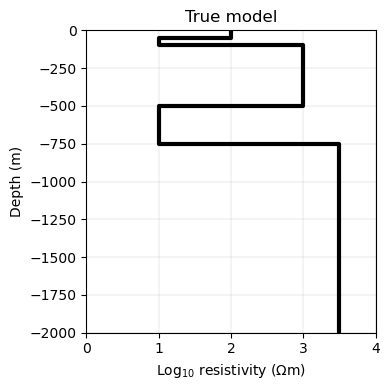

In [3]:
# layer electrical resitivity in log10 ohm.m 
true_model = np.array([2,1,3,1,3.5]) 
# depths in meters to the bottom of each layer (positive downwards), last layer infinite: len(true_depths)+1 = len(true_model)
true_depths = np.array([50,100,500,750])
# plot the model
max_depth = -2000
fig = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model')

#### 0.2. Compute response of the model

Compute synthetic data, add noise, define the data / errors and plot

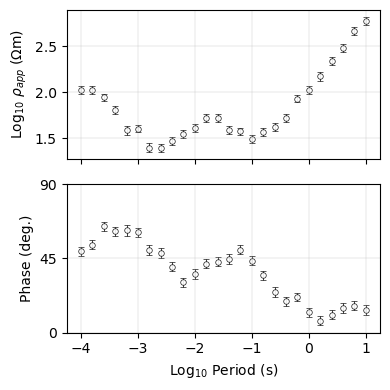

In [4]:
# define frequencies (in Hz) where responses are computed
fmin, fmax, f_per_decade = 1e-1, 1e4, 5
freqs = get_frequencies(fmin,fmax,f_per_decade)
# generate synthetic data 
# calculate impedance Z
Z = forward_1D_MT(true_model, true_depths, freqs, return_Z = True)
# add noise
Z, Zerr = add_noise(Z, percentage = 5, seed = 1234)
# transform Z to log10 apparent resistivity and phase (dobs)
dobs, derr = z2rhophy(freqs, Z, dZ=Zerr)
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [5]:
# the mesh used for the inversion contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 80, 5, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 102370.01 m


#### 0.4. Set new starting model and mesh

In [6]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)

## 1. Define the problem

In [7]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(mt.starting_model)

In [8]:
# add regularization: smoothing
smoothing_factor = 50
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg("smoothing", (mt.model_size,))
reg = reg_smoothing

In [9]:
def objective_func(model, reg):
    dpred = mt.forward(model)
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    model_reg = reg(model)
    return  data_misfit + model_reg

In [10]:
mt_problem.set_objective(objective_func, args=[reg])

In [11]:
#mt_problem.summary()

## 2. Define the inversion options

In [12]:
#mt_problem.suggest_tools();

In [13]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [14]:
#my_options.suggest_solver_params()

## 3. Start an inversion

In [15]:
print("Running inversion...")
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
print("   done!")

Running inversion...
   done!


In [16]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 65.65506193809989
jac: [ 0.06084235 -0.16377584 -0.28491627 -0.19269635 -0.16711113 -0.49443685
 -1.17818502 -1.82855048 -1.24753257  0.61475021  1.27828771  0.6889934
  0.6978425   0.90732897 -0.18482922 -1.05460885 -0.06738077  0.6314707
 -0.2530939  -0.62869248  0.36517634  0.77161531  0.01506066  0.0055465
  0.65766273 -0.09687682 -1.29097658 -0.39735966  1.09762227  0.3770424
 -0.93810542 -0.27204976  0.74873157  0.08998882 -0.68399118 -0.38260879
 -0.49363394 -1.12966064 -0.51929164  0.95054702  1.14427934 -0.18551134
 -1.20801787 -0.53353233  0.97986828  1.10117924 -0.40737121 -1.20620741
 -0.44785509  0.14669155  0.08092229  0.40867576  0.71330959  0.12888819
 -0.41239759 -0.02558238  0.65050756  0.9534773   0.78834717  0.14720172
 -0.58761316 -0.60552168  0.18976039  0.63948704  0.00347029 -1.00988871
 -1.02643015 -0.14498198 -0.1118778  -0.60558421 -0.42673776 -0.15976269
 -0.00319886 -0.04330758 -0.315787

## 4. Plotting inversion results

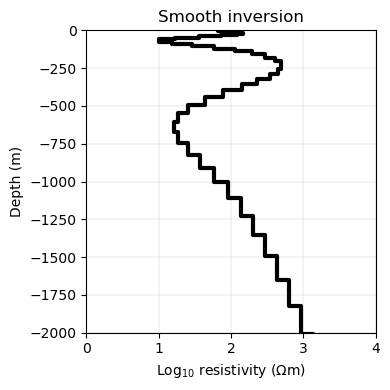

In [17]:
fig1 = mt.plot_model(inv_result.model, max_depth = max_depth, title='Smooth inversion');            # inverted model

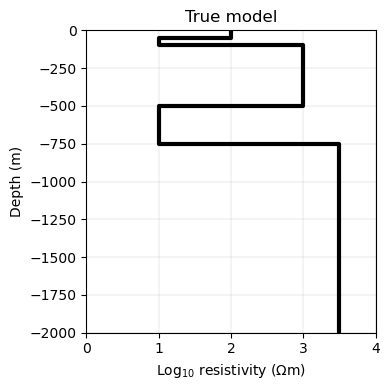

In [18]:
fig2 = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model');       # true model

nRMSE = 1.000


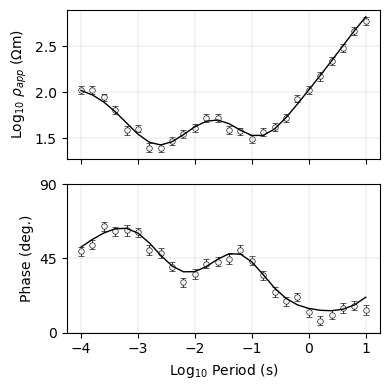

In [19]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model), Cm_inv = mt.inverse_covariance_matrix)/mt.data_size)
print('nRMSE = %.3f'%nRMSE)